In [96]:
# -*- coding: utf-8 -*-

import os
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt
import random



In [242]:
def load_exposures(source_dir, channel=0):
    filenames = []
    exposure_times = []
    f = open(os.path.join(source_dir, 'image_list.txt'))
    for line in f:
        if (line[0] == '#'):
            continue
        (filename, exposure, *rest) = line.split()
        filenames += [filename]
        exposure_times += [exposure]
    
    img_list = [cv2.imread(os.path.join(source_dir, f), 1) for f in filenames]
    img_list = [img[:,:,channel] for img in img_list]
    exposure_times = np.array(exposure_times, dtype=np.float32)

    return (img_list, exposure_times)


In [243]:
def hdr_debvec(img_list, exposure_times):
    B = [math.log(e,2) for e in exposure_times]
    l = 50
    w = [z if z <= 0.5*255 else 255-z for z in range(256)]

    small_img = [cv2.resize(img, (10, 10)) for img in img_list]
    Z = [img.flatten() for img in small_img]

    
    print(np.shape(Z))
    
    return response_curve_solver(Z, B, l, w)


In [250]:
def response_curve_solver(Z, B, l, w):
    n = 256
    A = np.zeros(shape=(np.size(Z, 0)*np.size(Z, 1)+n+1, n+np.size(Z, 1)), dtype=np.float32)
    b = np.zeros(shape=(np.size(A, 0), 1), dtype=np.float32)

    # Include the data−fitting equations
    k = 0
    for i in range(np.size(Z, 1)):
        for j in range(np.size(Z, 0)):
            z = Z[j][i]
            wij = w[z]
            A[k][z] = wij
            A[k][n+i] = -wij
            b[k] = wij*B[j]
            k += 1
    
    # Fix the curve by setting its middle value to 0
    A[k][128] = 1
    k += 1

    # Include the smoothness equations
    for i in range(n-1):
        A[k][i]   =    l*w[i+1]
        A[k][i+1] = -2*l*w[i+1]
        A[k][i+2] =    l*w[i+1]
        k += 1

    print(np.shape(A))
    print(np.shape(b))
    
    # Solve the system using SVD
    x = np.linalg.lstsq(A, b)[0]
    g = x[:256]
    lE = x[256:]
    print('done')

    return g, lE


In [251]:
# Loading exposure images into a list
img_list_b, exposure_times = load_exposures('test', 0)
img_list_g, exposure_times = load_exposures('test', 1)
img_list_r, exposure_times = load_exposures('test', 2)

gb, _ = hdr_debvec(img_list_b, exposure_times)
gg, _ = hdr_debvec(img_list_g, exposure_times)
gr, _ = hdr_debvec(img_list_r, exposure_times)

#print(x)


(16, 100)
(1857, 356)
(1857, 1)
done
(16, 100)
(1857, 356)
(1857, 1)
done
(16, 100)
(1857, 356)
(1857, 1)
done


In [246]:
g = x[0][:256]

In [247]:
lE= x[0][256:]

In [248]:
print(len(g),len(lE))
print(x[1])

256 100
[ 2305974.5]


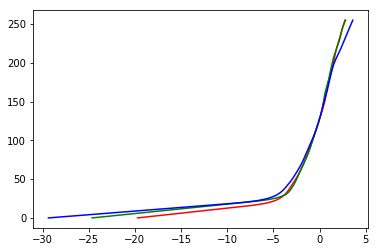

In [254]:
plt.plot(gr,range(256), 'r')
plt.plot(gg,range(256), 'g')
plt.plot(gb,range(256), 'b')
plt.show()